## 9-1. 프로젝트 : 모든 장르 간 편향성 측정해 보기

In [1]:
import os
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


**1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기**

---

In [2]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [3]:
print(len(tokenized))

71156


**2. 추출된 결과로 embedding model 만들기**

---





In [4]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

In [5]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7042560577392578),
 ('우정', 0.695254385471344),
 ('애정', 0.6929822564125061),
 ('첫사랑', 0.6892533302307129),
 ('진심', 0.6891855001449585),
 ('가슴', 0.6831523180007935),
 ('스팬리', 0.6817948818206787),
 ('만남', 0.6804770231246948),
 ('운명', 0.6788544058799744),
 ('감정', 0.6759063601493835)]

In [6]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.8998097777366638),
 ('영화감독', 0.8843104243278503),
 ('영감', 0.8735439777374268),
 ('공연', 0.8687884211540222),
 ('대본', 0.8667058944702148),
 ('오페라', 0.8657360672950745),
 ('시대극', 0.8650045990943909),
 ('캐스팅', 0.8634117841720581),
 ('각색', 0.8626280426979065),
 ('데뷔', 0.8610493540763855)]


**3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기**

---
WEAT score를 구할 때 단어 셋을 만들어주어야 합니다. targets_X, targets_Y, attribute_A, attribute_B를 만들어주었던 것이 기억나시죠? 이제 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 합니다.

여기서는 두 축을 영화 장르, 영화 구분 정보를 이용하겠습니다. (영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보입니다. KOBIS에서 제공한 정보를 기준으로 분류하였습니다.)

* 영화 구분
    - synopsis_art.txt : 예술영화
    - synopsis_gen.txt : 일반영화(상업영화)
    - 그 외는 독립영화 등으로 분류됩니다.


* 장르 구분

    - synopsis_SF.txt: SF

    - synopsis_가족.txt: 가족

    - synopsis_공연.txt: 공연

    - synopsis_공포(호러).txt: 공포(호러)

    - synopsis_기타.txt: 기타

    - synopsis_다큐멘터리.txt: 다큐멘터리

    - synopsis_드라마.txt: 드라마

    - synopsis_멜로로맨스.txt: 멜로로맨스

    - synopsis_뮤지컬.txt: 뮤지컬

    - synopsis_미스터리.txt: 미스터리

    - synopsis_범죄.txt: 범죄

    - synopsis_사극.txt: 사극

    - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)

    - synopsis_성인물(에로).txt: 성인물(에로)

    - synopsis_스릴러.txt: 스릴러

    - synopsis_애니메이션.txt: 애니메이션

    - synopsis_액션.txt: 액션

    - synopsis_어드벤처.txt: 어드벤처

    - synopsis_전쟁.txt: 전쟁

    - synopsis_코미디.txt: 코미디

    - synopsis_판타지.txt: 판타지

이번에는 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산해 보겠습니다. 즉 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것입니다.

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 위에서 했던 것과 마찬가지로 명사에 대해서만 추출하여 art, gen 변수에 할당하시기 바랍니다.

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [8]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요합니다. 예를 들면 예술영화라는 개념을 가장 잘 대표하는 단어들을 art_txt를 처리해서 만든 art라는 단어 리스트에서부터 골라내야 합니다. 이를 위해서 상식을 동원해서 적절한 단어를 골라낼 수도 있지만 보다 납득할 수 있는 보편적인 방법을 사용하는 것이 좋습니다.

어떤 개념을 나타내는 단어를 선정하는 방법으로 어떤 것이 적당할까요? 꼭 정해진 방법이 있는 것은 아닙니다. 그러나 이번 경우에는 예술영화, 일반영화라는 영화 구분별로 시놉시스를 모아 데이터를 구성했습니다. 그렇다면 예술영화를 잘 대표하는 단어란 예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당할 것입니다.

이런 것과 비슷한 개념의 단어 분석 방식 중, TF-IDF라는 것을 이미 접해 보셨을 것입니다. 즉, 코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정하고 싶은 것입니다. 이번에는 단어 셋 구성을 위해 TF-IDF방식을 사용하겠습니다. (그러나 이 방식이 최선이라는 의미는 아닙니다.)

TF-IDF에 관한 내용이 궁금하신 분은 [위키독스](https://wikidocs.net/31698) 를 참고하시기 바랍니다.

In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [10]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names_out()[23976])

23976
영화


In [11]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

어떤가요? 두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데, 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있습니다. 두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶기 때문에 단어가 서로 중복되지 않게 단어셋을 추출해야 합니다. 우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출합니다.

In [12]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

추출된 단어를 살펴볼까요?






In [13]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [14]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


이번에는 장르별 대표 단어를 추출해 봅시다. 이번에는 드라마 장르와 액션 장르를 다루어 보려고 합니다. 그러나 드라마와 액션 단 2개의 장르만 고려하기보다는 여러 장르의 코퍼스를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유리할 것입니다. 이번에는 주요 장르 5개만 고려해 봅시다.






In [15]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


In [16]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [18]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

각 장르를 대표하는 단어들을 추출해보았습니다. 우리가 생각했던 직관과 데이터에 있는 단어들이 잘 맞나요? 중복된 것이 종종 있지만 art, gen 두 개의 단어 셋을 추출했을 때에 비해 적습니다. 그러므로 중복을 체크해서 삭제하기보다 그대로 사용하겠습니다.



**4. WEAT score 계산과 시각화**

---


In [19]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev


In [20]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [21]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)


matrix를 채워보았습니다. WEAT score 값을 보고, 과연 우리의 직관과 비슷한지 살펴볼까요?



In [22]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.48330662
SF 공연 -0.35838178
SF 공포(호러) -0.6782784
SF 기타 0.35954168
SF 다큐멘터리 0.6057692
SF 드라마 -0.32552046
SF 멜로로맨스 -0.784065
SF 뮤지컬 0.3522577
SF 미스터리 -0.67028207
SF 범죄 -0.20019078
SF 사극 -0.81826204
SF 서부극(웨스턴) -0.42349422
SF 성인물(에로) -0.5521148
SF 스릴러 -0.5088922
SF 애니메이션 0.3710833
SF 액션 -0.443713
SF 어드벤처 -0.7687016
SF 전쟁 0.2437325
SF 코미디 -0.43215546
SF 판타지 -0.1595819
가족 공연 0.17489867
가족 공포(호러) -0.18303777
가족 기타 0.73431474
가족 다큐멘터리 0.8304899
가족 드라마 0.23856872
가족 멜로로맨스 -0.6255968
가족 뮤지컬 0.6881046
가족 미스터리 -0.3037438
가족 범죄 0.22638315
가족 사극 -0.08719569
가족 서부극(웨스턴) 0.3446569
가족 성인물(에로) -0.3108382
가족 스릴러 -0.13242231
가족 애니메이션 0.8453265
가족 액션 0.09524328
가족 어드벤처 -0.033188388
가족 전쟁 0.63105017
가족 코미디 0.17234159
가족 판타지 0.40985224
공연 공포(호러) -0.25813705
공연 기타 0.92355037
공연 다큐멘터리 0.9385405
공연 드라마 0.05661337
공연 멜로로맨스 -0.71005696
공연 뮤지컬 0.89538014
공연 미스터리 -0.34645057
공연 범죄 0.095717326
공연 사극 -0.38012612
공연 서부극(웨스턴) 0.015715988
공연 성인물(에로) -0.47792795
공연 스릴러 -0.20801976
공연 애니메이션 0.90956366
공연 액션 -0.03

***WEAT score가 0.8 이상, -0.8 이하의 경우***

In [23]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] >= 0.8 or matrix[i][j] <= -0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 사극 -0.81826204
가족 다큐멘터리 0.8304899
가족 애니메이션 0.8453265
공연 기타 0.92355037
공연 다큐멘터리 0.9385405
공연 뮤지컬 0.89538014
공연 애니메이션 0.90956366
기타 드라마 -0.8799734
기타 멜로로맨스 -0.9013816
기타 사극 -0.82653046
기타 성인물(에로) -0.82807934
다큐멘터리 드라마 -0.9237322
다큐멘터리 멜로로맨스 -0.9105084
다큐멘터리 사극 -0.9188769
다큐멘터리 성인물(에로) -0.8458656
다큐멘터리 어드벤처 -0.9560157
다큐멘터리 코미디 -0.8421425
다큐멘터리 판타지 -0.9194454
드라마 멜로로맨스 -0.8515418
드라마 뮤지컬 0.8248228
드라마 애니메이션 0.87869054
멜로로맨스 뮤지컬 0.8734641
멜로로맨스 범죄 0.8554206
멜로로맨스 성인물(에로) 0.81331784
멜로로맨스 애니메이션 0.88490206
멜로로맨스 코미디 0.90237737
멜로로맨스 판타지 0.8319914
뮤지컬 사극 -0.80789036
뮤지컬 성인물(에로) -0.8023262
미스터리 범죄 1.0399584
범죄 스릴러 -0.9921355
사극 애니메이션 0.83807784
사극 전쟁 0.8723748
애니메이션 어드벤처 -0.88074213


WEAT score가 0.8 이상, -0.8 이하의 경우만 해석해 보면 아래와 같습니다.


 * 예술영화와 일반영화, 그리고 SF와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 SF, 일반영화는 멜로로맨스와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 SF와 사극의 WEAT score의 의미를 해석해보면 예술영화는 SF, 일반영화는 사극와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 SF와 어드벤처의 WEAT score의 의미를 해석해보면 예술영화는 SF, 일반영화는 어드벤처와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 가족와 다큐멘터리의 WEAT score의 의미를 해석해보면 예술 영화는 가족와 가깝고, 다큐멘터리는 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 가족와 애니메이션의 WEAT score의 의미를 해석해보면 예술 영화는 가족와 가깝고, 애니메이션는 일반 영화와 가깝다고 볼 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 공연와 기타의 WEAT score의 의미를 해석해보면 예술 영화는 공연와 가깝고, 기타은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 공연와 다큐멘터리의 WEAT score의 의미를 해석해보면 예술 영화는 공연와 가깝고, 다큐멘터리은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 공연와 뮤지컬의 WEAT score의 의미를 해석해보면 예술 영화는 공연와 가깝고, 뮤지컬은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 공연와 애니메이션의 WEAT score의 의미를 해석해보면 예술 영화는 공연와 가깝고, 애니메이션은 일반 영화와 가깝다고 볼 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 기타와 드라마의 WEAT score의 의미를 해석해보면 예술영화는 기타, 일반영화는 드라마와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 기타와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 기타, 일반영화는 멜로로맨스와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 기타와 사극의 WEAT score의 의미를 해석해보면 예술영화는 기타, 일반영화는 사극와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 기타와 성인물(에로)의 WEAT score의 의미를 해석해보면 예술영화는 기타, 일반영화는 성인물(에로)와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 기타와 어드벤처의 WEAT score의 의미를 해석해보면 예술영화는 기타, 일반영화는 어드벤처와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 다큐멘터리와 드라마의 WEAT score의 의미를 해석해보면 예술영화는 다큐멘터리, 일반영화는 드라마와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 다큐멘터리와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 다큐멘터리, 일반영화는 멜로로맨스와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 다큐멘터리와 사극의 WEAT score의 의미를 해석해보면 예술영화는 다큐멘터리, 일반영화는 사극와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 다큐멘터리와 성인물(에로)의 WEAT score의 의미를 해석해보면 예술영화는 다큐멘터리, 일반영화는 성인물(에로)와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 다큐멘터리와 어드벤처의 WEAT score의 의미를 해석해보면 예술영화는 다큐멘터리, 일반영화는 어드벤처와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 다큐멘터리와  코미디의 WEAT score의 의미를 해석해보면 예술영화는 다큐멘터리, 일반영화는  코미디와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 다큐멘터리와  판타지의 WEAT score의 의미를 해석해보면 예술영화는 다큐멘터리, 일반영화는  판타지와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 드라마와  멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 드라마, 일반영화는  멜로로맨스와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
 * 예술영화와 일반영화, 그리고 드라마와 뮤지컬의 WEAT score의 의미를 해석해보면 예술 영화는 드라마와 가깝고, 뮤지컬은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 드라마와 애니메이션의 WEAT score의 의미를 해석해보면 예술 영화는 드라마와 가깝고, 애니메이션은 일반 영화와 가깝다고 볼 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 멜로로맨스와 뮤지컬의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 뮤지컬은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 멜로로맨스와 범죄의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 범죄은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 멜로로맨스와 성인물(에로)의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 성인물(에로)은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 멜로로맨스와 애니메이션의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 애니메이션은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 멜로로맨스와 코미디의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 코미디은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 멜로로맨스와 판타지의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 판타지은 일반 영화와 가깝다고 볼 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 뮤지컬와 사극의 WEAT score의 의미를 해석해보면 예술 영화는 뮤지컬와 가깝고, 사극은 일반 영화와 가깝다고 볼 수 있습니다.부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 미스터리와 범죄의 WEAT score의 의미를 해석해보면 예술 영화는 미스터리와 가깝고, 범죄은 일반 영화와 가깝다고 볼 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 범죄와 스릴러의 WEAT score의 의미를 해석해보면 예술 영화는 범죄와 가깝고, 스릴러은 일반 영화와 가깝다고 볼 수 있습니다.부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 사극와 애니메이션의 WEAT score의 의미를 해석해보면 예술 영화는 사극와 가깝고, 애니메이션은 일반 영화와 가깝다고 볼 수 있습니다.
 * 예술영화와 일반영화, 그리고 사극와 전쟁의 WEAT score의 의미를 해석해보면 예술 영화는 사극와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있습니다.

---
 * 예술영화와 일반영화, 그리고 애니메이션와 어드벤처의 WEAT score의 의미를 해석해보면 예술 영화는 애니메이션와 가깝고, 어드벤처은 일반 영화와 가깝다고 볼 수 있습니다.부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.


<AxesSubplot:>

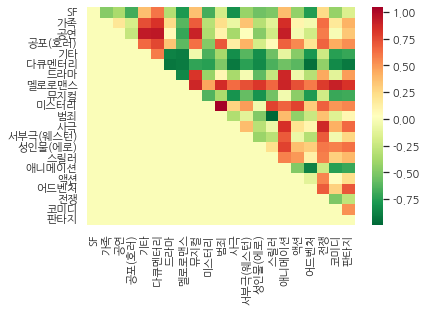

In [25]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=False,  cmap='RdYlGn_r')
ax